In [81]:
# Author: Michael Djaballah
# Last edited 11:25 PM June 14, 2020
# Last edited by: Michael Djaballah

import yfinance as yf
import pandas as pd
from datetime import datetime
import os
from time import sleep
from dateutil.relativedelta import relativedelta
import sklearn as sk
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [1]:
'''
Variable ordering
- Portfolio
- ticker(s)
- features
- model
- date
- date format
- historical depth
- training depth
- start
- end
- interval
- data path
- prefix 
'''

'\nVariable ordering\n- Portfolio\n- ticker(s)\n- features\n- model\n- date\n- date format\n- historical depth\n- training depth\n- start\n- end\n- interval\n- data path\n- prefix \n'

In [2]:
data_path = 'data/'
date_format = '%B %d, %Y'
start = '2000-01-01'
interval = '1mo'
prefix = 'monthly/'

In [3]:
# Functions to maintain and call the S&P 500 from a current date
# Author Michael Djaballah
# Time last edited: 11:03 PM June 14, 2020
# Last edited by: Michael Djaballah

# Takes no input
# Output is newly saved CSV's containing the current makeup of the S&P 500 
# and its historical additions and removals
# data_path is changeable depending on desired save location
def get_snp_store(data_path='data/'):
    curr_raw = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    
    curr = curr_raw[0]
    hist = curr_raw[1]
    
    new_hist = pd.DataFrame(hist['Date'])
    new_hist['Added'] = hist['Added', 'Ticker']
    new_hist['Removed'] = hist['Removed', 'Ticker']
    
    os.makedirs(data_path, exist_ok=True)
    
    curr.to_csv(data_path + 'snp_current.csv', index=False)
    new_hist.to_csv(data_path + 'snp_hist.csv', index=False)
    return None


# Input: a date in string form with its corresponding format:
# Ex: 'January 1, 2020', '%B %d, %Y'
# Output: a list containing the S&P 500 at the input date
def build_snp(date, date_format='%Y-%m-%d', data_path='data/'):
    get_snp_store(data_path=data_path)
    curr = pd.read_csv(data_path + 'snp_current.csv')
    hist = pd.read_csv(data_path + 'snp_hist.csv')
    
    start_date = datetime.strptime(date, date_format)
    
    snp_set = set(curr['Symbol'])
    
    for i in range(len(hist)):
        temp_date = datetime.strptime(hist.iloc[i]['Date'], date_format)
        if temp_date < start_date:
            break

        tb_removed = hist.iloc[i]['Added']
        tb_added = hist.iloc[i]['Removed']

        if tb_removed in snp_set:
            snp_set.remove(tb_removed)
        if not type(tb_added) == float:
            snp_set.add(tb_added)
    
    return list(snp_set)

In [4]:
# Functions to obtain data from yfinance
# Author Michael Djaballah
# Time last edited: 11:21 PM June 14, 2020
# Last edited by: Michael Djaballah

# Takes a list of tickers as strings
# Output is newly saved CSV's with one CSV per company 
# Saved in specific directory
# data_path is changeable depending on desired save location
def get_data(tickers, start='2000-01-01', interval='1mo', data_path='data/', prefix='monthly/', return_bad_tickers=False):
    bad_tickers = []
    
    os.makedirs(data_path + prefix, exist_ok=True)
    
    curr_tickers = set(os.listdir(data_path + prefix))

    for ticker in tickers:
        ticker_label = ticker + '.csv'
        
        if ticker_label not in curr_tickers:
            temp_ticker = yf.Ticker(ticker)
            temp_hist = temp_ticker.history(start=start, interval=interval)
            temp_hist.dropna(axis=0, inplace=True)
            temp_hist.to_csv(data_path + prefix + ticker_label)
            
            if len(temp_hist) < 90:
                bad_tickers.append((ticker, len(temp_hist)))
            sleep(.5)
    
    if return_bad_tickers:
        return bad_tickers
    
    return None

In [5]:
# Functions to manipulate and extract desired data from data saved with "get_data"
# Author Michael Djaballah
# Time last edited: 11:21 PM June 14, 2020
# Last edited by: Michael Djaballah


# Takes a ticker as a string
# Output is either a dataframe with desired data, or False, indicating that there was not enough data to build with the desired offset
# data_path is changeable depending on desired save location
def check_ticker(ticker, offset, data_path='data/', prefix='monthly/'):
    ticker_df = pd.read_csv(data_path + prefix + ticker + '.csv')
    if len(ticker_df) >= offset:
        return ticker_df
    return False


# Takes a list of tickers as strings, the test depth and historical depth
# Output is a dictionary of data frames: key = ticker string, value = dataframe
# data_path is changeable depending on desired save location
def build_portfolio(tickers, hist_depth, train_depth, start='2000-01-01', interval='1mo', data_path='data/', prefix='monthly/'):
    offset = train_depth + hist_depth + 60 + 6
    
    get_data(tickers, data_path=data_path, start=start, interval=interval, prefix=prefix)
    
    ticker_dict = {}
    
    for ticker in tickers:
        ticker_df = check_ticker(ticker, offset)
        if type(ticker_df) != bool:
            ticker_dict[ticker] = ticker_df
    
    return ticker_dict


# Takes a portfolio (from 'build_portfolio'), a desired ticker, date desired to predict on, depth desired, and features desired
# Output is a dataframe with one row or the desired features from previous dates
# Can change 'keep_pred' to True if training or False if predicting
# Target value is present in 'Target' column if 'keep_pred' = True
def build_feature_vector(portfolio, ticker, features, date, hist_depth, target='Close', keep_pred=True):
    ticker_df = portfolio[ticker]
    
    start_date_dt = datetime.strptime(date, '%Y-%m-%d') - relativedelta(months=hist_depth)
    start_date = start_date_dt.strftime('%Y-%m-%d')
    
    feature_df = ticker_df.set_index('Date')[start_date:date].reset_index(drop=True)[features]
    
    new_df_dict = {}
    
    for i in range(len(feature_df)):
        for col in feature_df.columns:
            if i < len(feature_df) - 1:
                new_df_dict[col + ' ' + str(i + 1)] = [feature_df[col].iloc[i]]
            elif col == target:
                if keep_pred:
                    new_df_dict['Target'] = [feature_df[col].iloc[i]]
                    
    new_df = pd.DataFrame.from_dict(new_df_dict)
    
    if keep_pred:
        new_df = new_df[[col for col in new_df.columns if col not in {'Target'}] + ['Target']]
    
    return new_df

In [180]:
# 
# Author Michael Djaballah
# Time last edited: 11:21 PM June 14, 2020
# Last edited by: Michael Djaballah

# Input: portfolio, features, date that the training is to go to, both depths
# Output: dataframe with all features for all training months for the portfolio
# 
# 
def build_train_df(portfolio, features, date, hist_depth, train_depth, target='Close'):    
    tickers = portfolio.keys()
    
    vector_list = []
    for ticker in tickers:
        for i in range(train_depth):
            train_start_dt = datetime.strptime(date, '%Y-%m-%d') - relativedelta(months=(1+i))
            train_start = train_start_dt.strftime('%Y-%m-%d')
            vector_list.append(build_feature_vector(portfolio, features, ticker, train_start, hist_depth, target=target))
            
    feature_df = pd.concat(vector_list)
    return feature_df.reset_index(drop=True)


# Input: portfolio, features, date, historical depth
# Output: dataframe missing y's to predict with and an index list to show which ticker is where in the dataframe
# 
# 
def build_test_df(portfolio, features, date, hist_depth, target='Close'):
    tickers = portfolio.keys()
    
    vector_list = []
    index_list = []
    for ticker in tickers:
        vector_list.append(build_feature_vector(portfolio, features, ticker, date, hist_depth, target=target, keep_pred=False))
        index_list.append(ticker)
        
    test_df = pd.concat(vector_list)
    return test_df.reset_index(drop=True), index_list


# Input: portfolio, desired list of tickers to get returns for, and the date of those returns
# Output: list of returns for those tickers
# 
# 
def build_returns(portfolio, tickers, date):
    returns = []
    for ticker in tickers:
        temp_ticker_dict = portfolio[ticker].set_index('Date').loc[date]
        returns.append((temp_ticker_dict['Close'] - temp_ticker_dict['Open'])/temp_ticker_dict['Open'])
    return returns


# Input: Dataframe
# Output: Dataframe scaled to standard
# 
# 
def build_scaled_df(dataframe):
    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(dataframe)
    scaled_dataframe = pd.DataFrame(scaled_array, columns=dataframe.columns)
    return scaled_dataframe


# Input: Portfolio, model, date, features, and depths
# Output: top 15 tickers from universe
# 
# 
def build_machine(portfolio, features, model, date, hist_depth, train_depth):
    train_df = build_train_df(portfolio, features, date, hist_depth, train_depth)
    scaled_train_df = build_scaled_df(train_df)
    
    scaled_train_df.dropna(axis=0, inplace=True)
    
    X = scaled_train_df.values[:,:-1]
    y = scaled_train_df.values[:, -1]
    model.fit(X, y)
    
    test_df, tickers = build_test_df(portfolio, features, date, hist_depth)
    scaled_test_df = build_scaled_df(test_df)
    X_test = scaled_test_df.values
    
    predicted_returns = list(model.predict(X))
    
    returns_dict = {}
    
    for i in range(len(tickers)):
        returns_dict[tickers[i]] = predicted_returns[i]
        
    top_15 = sorted(returns_dict.items(), key=lambda x: x[1])[::-1][:15]
    return [x[0] for x in top_15]

# Input: all things needed to build a machine with a date range to test
# Output: per date average returns as determined by the model
# 
# 
def backtest(portfolio, features, model, hist_depth, train_depth, start_date, end_date):
    months = list(pd.date_range(start_date, end_date, freq='MS').strftime('%Y-%m-%d'))
    
    overall_returns = []
    for month in months:
        tickers = build_machine(portfolio, features, month, model, hist_depth, train_depth)
        ticker_returns = build_returns(portfolio, tickers, month)
        overall_returns.append(sum(ticker_returns)/len(ticker_returns))
        print(month, sum(ticker_returns)/len(ticker_returns))
    return overall_returns

In [181]:
hist_depth = 24
train_depth = 3
features = ['Close', 'Volume']
start_date = '2015-01-01'
end_date = '2019-12-01'

In [182]:
universe = build_snp('January 1, 2015', date_format)

In [183]:
%%time
port2 = build_portfolio(universe, hist_depth, train_depth)
print(len(port2.keys()))

422
CPU times: user 938 ms, sys: 71.3 ms, total: 1.01 s
Wall time: 1.21 s


In [184]:
from sklearn.ensemble import RandomForestRegressor

In [185]:
rfr = RandomForestRegressor(n_estimators=50, random_state=407, n_jobs=-1)

In [186]:
%%time
results = backtest(port2, features, frf, hist_depth, train_depth, start_date, end_date)

2015-01-01 0.09152643901979256
2015-02-01 0.06928853494705951
2015-03-01 -0.005986957968727735
2015-04-01 0.02195623483693711
2015-05-01 -0.0057297212193271494
2015-06-01 -0.022192067375588553
2015-07-01 -0.0065094826161160085
2015-08-01 -0.06324140346883583
2015-09-01 -0.038162388518633565
2015-10-01 -0.0019063943605810865
2015-11-01 0.02096724524227795
2015-12-01 -0.055781658353768755
2016-01-01 0.023621484929560236
2016-02-01 0.03368738914641459
2016-03-01 0.08556171850441298
2016-04-01 0.008673652347099731
2016-05-01 0.00790170548910662
2016-06-01 0.0024678335037559077
2016-07-01 0.07134316208717627
2016-08-01 0.01672851343156442
2016-09-01 0.001565439331017141
2016-10-01 -0.0036615186788194
2016-11-01 0.07998881848344228
2016-12-01 -0.020369259780807118
2017-01-01 -0.0714640914797487
2017-02-01 0.0007186619803833209
2017-03-01 -0.004601476176026516
2017-04-01 -0.011746228284431271
2017-05-01 -0.007497112232382612
2017-06-01 0.02692916050852757
2017-07-01 0.030524918084588293
2017-

In [187]:
starting_capital = 1000
historical = [starting_capital]
for i in range(len(results)):
    starting_capital *= (results[i] + 1)
    historical.append(starting_capital)

In [188]:
historical[-1]

1872.2507182579907

In [189]:
min(historical)

992.7965239776622

In [190]:
spy = yf.Ticker('SPY').history(period='max', interval='1mo').reset_index().dropna()
port3 = {'SPY': spy}
months = list(pd.date_range(start_date, end_date, freq='MS').strftime('%Y-%m-%d'))

starting_capital = 1000
historical_spy = [starting_capital]
for month in months:
    returns = build_returns(port3, ['SPY'], month)[0]
    starting_capital *= (returns + 1)
    historical_spy.append(starting_capital)
    
df_dict = {'SPY': historical_spy, 'Port':historical}
compare_df = pd.DataFrame.from_dict(df_dict)

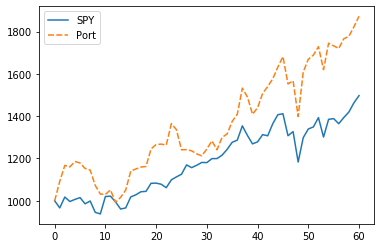

In [191]:
sns.lineplot(data=compare_df)

In [163]:
%%time
build_train_df(port2, features, '2015-01-01', hist_depth, train_depth)

CPU times: user 9.37 s, sys: 36.6 ms, total: 9.41 s
Wall time: 9.41 s


,Close 1,Volume 1,Close 2,Volume 2,Close 3,Volume 3,Close 4,Volume 4,Close 5,Volume 5,...,Volume 20,Close 21,Volume 21,Close 22,Volume 22,Close 23,Volume 23,Close 24,Volume 24,Target
0,23.04,81071900.0,23.97,87251000.0,24.20,74635100.0,20.08,87937600.0,24.71,92407800.0,...,85144300.0,30.99,55706700.0,31.09,64699100.0,31.65,122396800.0,31.41,66214400.0,32.70
1,22.30,113058600.0,23.04,81071900.0,23.97,87251000.0,24.20,74635100.0,20.08,87937600.0,...,68590600.0,9.92,85144300.0,30.99,55706700.0,31.09,64699100.0,31.65,122396800.0,31.41
2,22.78,114434100.0,22.30,113058600.0,23.04,81071900.0,23.97,87251000.0,24.20,74635100.0,...,59038200.0,22.41,68590600.0,9.92,85144300.0,30.99,55706700.0,31.09,64699100.0,31.65
3,52.08,64340800.0,54.46,82553800.0,56.80,80061000.0,59.61,70351800.0,61.94,88470800.0,...,64156600.0,92.06,58848900.0,95.27,59065200.0,102.32,116442800.0,102.60,66521600.0,105.10
4,50.29,73206200.0,52.08,64340800.0,54.46,82553800.0,56.80,80061000.0,59.61,70351800.0,...,65316500.0,85.97,64156600.0,92.06,58848900.0,95.27,59065200.0,102.32,116442800.0,102.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1261,50.48,30515300.0,56.45,39691400.0,59.30,28304300.0,58.12,33868200.0,58.23,27167300.0,...,20564200.0,67.32,28695900.0,70.47,22005600.0,69.12,28061300.0,69.32,40842300.0,71.15
1262,49.14,39233700.0,50.48,30515300.0,56.45,39691400.0,59.30,28304300.0,58.12,33868200.0,...,22735100.0,74.35,20564200.0,67.32,28695900.0,70.47,22005600.0,69.12,28061300.0,69.32
1263,51.03,63200100.0,56.13,84161200.0,59.28,151433200.0,56.79,107543700.0,56.94,83830300.0,...,89260500.0,80.12,76775000.0,71.39,83630400.0,78.59,64057600.0,76.71,98694900.0,75.10
1264,53.15,83160600.0,51.03,63200100.0,56.13,84161200.0,59.28,151433200.0,56.79,107543700.0,...,56776200.0,81.48,89260500.0,80.12,76775000.0,71.39,83630400.0,78.59,64057600.0,76.71


In [164]:
%%time
test_df, ticker_list = build_test_df(port2, features, '2015-01-01', hist_depth)

CPU times: user 2.83 s, sys: 10.2 ms, total: 2.84 s
Wall time: 2.84 s


In [180]:
%%time
build_scaled_df(test_df)

,Close 1,Volume 1,Close 2,Volume 2,Close 3,Volume 3,Close 4,Volume 4,Close 5,Volume 5,...,Close 20,Volume 20,Close 21,Volume 21,Close 22,Volume 22,Close 23,Volume 23,Close 24,Volume 24
0,-0.123685,-0.147447,-0.125749,-0.162539,-0.136233,-0.088595,-0.130326,-0.122766,-0.125271,-0.129971,...,-0.155595,-0.167414,-0.170414,-0.142554,-0.175475,-0.009897,-0.184104,-0.118898,-0.187707,-0.160849
1,-0.056002,-0.163728,-0.051995,-0.139128,-0.048142,-0.165145,-0.046225,-0.138495,-0.045689,-0.199743,...,-0.027127,-0.141428,-0.004381,-0.179160,0.012297,-0.040765,0.014696,-0.116180,0.025945,-0.050064
2,-0.069232,-0.378311,-0.081474,-0.431866,-0.083485,-0.426684,-0.083340,-0.430797,-0.083932,-0.453740,...,-0.106665,-0.473729,-0.120692,-0.356612,-0.107429,-0.458316,-0.105829,-0.599415,-0.105935,-0.544208
3,-0.100288,-0.215079,-0.099822,-0.260052,-0.097525,-0.279429,-0.096667,-0.225821,-0.106877,-0.225284,...,-0.129216,-0.175556,-0.140276,-0.288191,-0.132671,-0.283900,-0.140261,-0.274172,-0.136212,-0.300967
4,-0.032782,-0.329112,-0.012562,-0.361945,-0.006426,-0.337086,-0.025556,-0.330474,-0.029124,-0.369050,...,-0.060532,-0.372051,-0.080801,-0.287415,-0.083303,-0.356890,-0.094017,-0.324346,-0.131225,-0.116790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,-0.133963,-0.325849,-0.134323,-0.289177,-0.128455,-0.204975,-0.133578,-0.301794,-0.130613,-0.292726,...,-0.155364,-0.395463,-0.174580,-0.364536,-0.183340,-0.443559,-0.191895,-0.402916,-0.195527,-0.311815
418,-0.054937,-0.358371,-0.051860,-0.363872,-0.044087,-0.325782,-0.045728,-0.377379,-0.038913,-0.378924,...,0.006194,-0.487443,0.024361,-0.444787,0.029488,-0.508930,0.045442,-0.592042,0.053803,-0.537504
419,0.055923,-0.330610,0.033137,-0.360007,0.017530,-0.353200,-0.013493,-0.280766,-0.007280,-0.363912,...,0.040462,-0.461327,0.056336,-0.455542,0.067191,-0.489858,0.088950,-0.557163,0.100812,-0.550358
420,-0.045258,-0.351768,-0.049009,-0.338442,-0.051218,-0.353126,-0.060140,-0.331113,-0.055478,-0.335967,...,-0.072544,-0.446115,-0.072031,-0.380605,-0.075385,-0.432710,-0.073129,-0.467197,-0.092094,-0.409926
